In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
from sklearn.cluster import KMeans
from os.path import join
from os import path
import time
from typing import Tuple
from sklearn.cluster import k_means

from itertools import count
from functools import partial

from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt

In [2]:
def construct_undistort_map(image_size, folder):
    mtx = np.load(join(folder, "mtx_file.npy"))
    dist = np.load(join(folder, "dist_file.npy"))
    newcameramtx = np.load(join(folder, "newcameramtx_file.npy"))

    mapping = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, image_size, 5)
    return mapping

In [3]:
def default_blob_detector_params():
    # Setup SimpleBlobDetector parameters.
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 20
    params.maxThreshold = 150

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 15
    params.maxArea = 60
    params.minDistBetweenBlobs = 1.0

    # Turn off other filters
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False

    return params

In [4]:
def preprocessing(image, mapping, mask):
    processed_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    processed_image = cv.remap(processed_image, *mapping, cv.INTER_LINEAR)
    processed_image[~mask] = 255
    return processed_image

In [5]:
def blob_detector_localization(image):
    blob_detector = cv.SimpleBlobDetector_create(default_blob_detector_params())
    keypoints = blob_detector.detect(image)  # get keypoints
    return np.array([keypoint.pt for keypoint in keypoints])

In [6]:
def initialize(loader, n_frames):
    n_blobs = []
    for frame_idx in count():
        image = loader()
        locations = blob_detector_localization(image)
        n_blobs.append(locations.shape[0])

        if len(n_blobs) >= n_frames:
            n_flies = int(np.median(n_blobs))
            if (n_blobs[-1] == n_flies):
                break

    return n_flies, locations, frame_idx

In [7]:
# Creating mask
mask = np.ones((1080, 1280), dtype=np.bool)  # assumes 1080 x 1280 resolution
mask[:110, :] = 0
mask[-110:, :] = 0
mask[:, :180] = 0
mask[:, -260:] = 0

In [8]:
#movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/clement/seq_1.h264"
capture = cv.VideoCapture(movie_path)
image_size = (
    int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
)

In [9]:
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
mapping = construct_undistort_map(image_size, mapping_folder)

In [10]:
# Building loader function
loader = lambda: preprocessing(capture.read()[1], mapping=mapping, mask=mask)

In [11]:
n_flies, initial_locations, initial_frame = initialize(loader, 100)

In [12]:
def localize_kmeans(image, init, threshold=120):
    n_flies = init.shape[0]
    fly_pixels = cv.findNonZero((image < threshold).astype("uint8")).squeeze()
    locations = KMeans(n_clusters=n_flies, n_init=1, init=init).fit(fly_pixels).cluster_centers_
    return locations

In [13]:
def hungarian(locs_new, locs_prev):
    new_ordering = linear_sum_assignment(distance_matrix(locs_new, locs_prev))[1]
    return locs_new[new_ordering]

In [14]:
def localize(loader, initial_position, n_frames=None):
    locations = [initial_position]
    for idx in count():
        try:
            image = loader()
        except:
            break # finished
        
        locations.append(hungarian(localize_kmeans(image, locations[-1]), locations[-1]))
        
        if idx % 1000 == 0:
            print(f"Done with frame {idx}")
        if idx + 1 == n_frames:
            break # max number of frames
    return locations

In [15]:
%%time
locs = localize(loader, initial_locations, n_frames=10000)
locs = np.array(locs)

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
CPU times: user 24min 29s, sys: 3min, total: 27min 30s
Wall time: 1min 14s


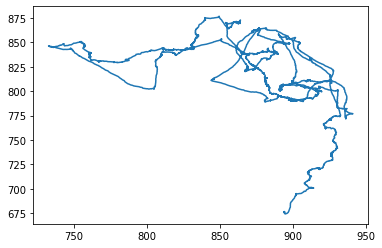

In [16]:
ID = 1
plt.plot(locs[:, ID, 0], locs[:, ID, 1], '-')

In [17]:
diff = np.linalg.norm(np.diff(locs, axis=0), axis=2)

(array([3.99996e+05, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([  0.        ,  23.05461484,  46.10922968,  69.16384452,
         92.21845937, 115.27307421, 138.32768905, 161.38230389,
        184.43691873, 207.49153357, 230.54614842]),
 <BarContainer object of 10 artists>)

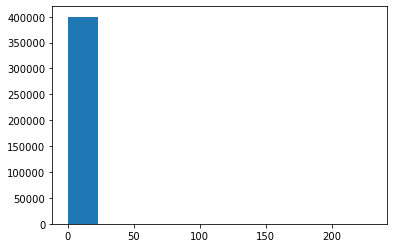

In [18]:
plt.hist(diff.flatten())

In [19]:
def post_process(locations, initial_frame, n_arenas):
    n_frames = len(locations)
    n_flies = len(locations[0])
    identities = (
        np.arange(n_flies)[None, :] * np.ones((n_frames, n_flies))
    ).reshape(
        -1, 1
    )  # we get free tracking from the kmeans
    frames = (
        np.arange(initial_frame, n_frames + initial_frame)[:, None]
        * np.ones((n_frames, n_flies))
    ).reshape(-1, 1)
    df = pd.DataFrame(
        np.concatenate(
            [frames, identities, np.concatenate(locations, axis=0)], axis=1
        ),
        columns=["frame", "ID", "x", "y"],
    )

    # Localizing flies per arena
    x_ave = df.pivot_table(index="ID", columns="frame", values="x").mean(axis=1)
    y_ave = df.pivot_table(index="ID", columns="frame", values="y").mean(axis=1)
    labels = k_means(np.stack([x_ave, y_ave], axis=1), n_arenas)[1]
    df["arena"] = (labels[None, :] * np.ones((df.frame.unique().size, 1))).flatten()
    return df

In [20]:
df = post_process(list(locs), initial_frame, n_arenas=4)

In [21]:
df

,frame,ID,x,y,arena
0,99.0,0.0,884.281189,861.476074,2.0
1,99.0,1.0,889.688843,838.107544,2.0
2,99.0,2.0,864.611633,837.241516,2.0
3,99.0,3.0,848.874207,835.064087,2.0
4,99.0,4.0,806.007935,820.360840,2.0
...,...,...,...,...,...
400035,10099.0,35.0,446.609756,484.731707,3.0
400036,10099.0,36.0,400.105263,504.394737,3.0
400037,10099.0,37.0,518.270270,266.432432,3.0
400038,10099.0,38.0,372.520000,306.240000,3.0


In [22]:
locs.shape

(10001, 40, 2)

In [23]:
def run(movie_path, mapping_folder, mask, n_arenas, n_frames=None, n_ini=100):
    # Constructing loader
    capture = cv.VideoCapture(movie_path)
    image_size = (
            int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
            int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
        )
    mapping = construct_undistort_map(image_size, mapping_folder)
    loader = lambda: preprocessing(capture.read()[1], mapping=mapping, mask=mask)
    
    # Actual logic
    n_flies, initial_locations, initial_frame = initialize(loader, n_ini)
    locs = localize(loader, initial_locations, n_frames=n_frames)
    df = post_process(locs, initial_frame, n_arenas=n_arenas)
    return df

In [12]:
# Creating mask
mask = np.ones((1080, 1280), dtype=np.bool)  # assumes 1080 x 1280 resolution
mask[:110, :] = 0
mask[-110:, :] = 0
mask[:, :180] = 0
mask[:, -260:] = 0

In [13]:
%%time
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
df = run(movie_path, mapping_folder, mask, n_arenas=4, n_frames=1000)

Done with frame 0
CPU times: user 2min 29s, sys: 23.3 s, total: 2min 53s
Wall time: 7.67 s


In [16]:
%%time
df = run(movie_path, mapping_folder, mask, n_arenas=4)

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
Done with frame 11000
Done with frame 12000
Done with frame 13000
Done with frame 14000
Done with frame 15000
Done with frame 16000
Done with frame 17000
Done with frame 18000
Done with frame 19000
Done with frame 20000
Done with frame 21000
Done with frame 22000
Done with frame 23000
Done with frame 24000
Done with frame 25000
Done with frame 26000
Done with frame 27000
Done with frame 28000
Done with frame 29000
Done with frame 30000
Done with frame 31000
Done with frame 32000
Done with frame 33000
Done with frame 34000
Done with frame 35000
Done with frame 36000
Done with frame 37000
Done with frame 38000
Done with frame 39000
Done with frame 40000
Done with frame 41000
Done with frame 42000
Done with frame 43000
Done with frame 44000
Done with frame 45000
D

In [19]:
df.to_hdf('df_new.hdf', key='df', complevel=9, complib='blosc')

In [20]:
df = df.sort_values(by=['frame', 'ID'])

In [25]:
n_flies = df.ID.unique().size

In [28]:
change = np.linalg.norm(np.diff(df[['x', 'y']].to_numpy().reshape(-1, n_flies, 2), axis=0), axis=2)

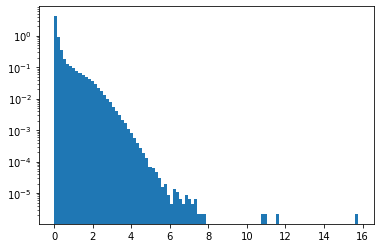

In [35]:
plt.hist(change.flatten(), bins=100, log=True, density=True)
plt.show()